# 📌 Project Overview

In this project, we build a **Sentiment Analysis model** using the well-known **Sentiment140 dataset**, which contains **1.6 million tweets** annotated for polarity.  
Our objective is to classify text into **Positive** or **Negative** sentiment. (Originally the dataset schema included a Neutral label, but the public release contains only Positive and Negative.)

### What we will do:
- Download and explore the dataset.
- Preprocess and clean the raw text.
- Train a scalable machine learning pipeline.
- Evaluate the model on validation and test splits.
- Deploy the final model as a **Streamlit app** for live predictions.

---

## 📂 Step 1: Load and Explore the Dataset
We start by downloading the dataset using `kagglehub`.  
Then, we load it into a DataFrame, map numeric labels (`0`, `4`) into human-readable classes (**Negative**, **Positive**), and check the class distribution.


In [19]:
import pandas as pd
import kagglehub
import os

# Download dataset via kagglehub
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Dataset files are here:", path)
print("Files inside:", os.listdir(path))

# Load the main CSV (training.1600000.processed.noemoticon.csv)
csv_file = os.path.join(path, "training.1600000.processed.noemoticon.csv")

df = pd.read_csv(csv_file, encoding="latin-1", header=None, names=[
    "target","ids","date","flag","user","text"
])

# Map labels
label_map = {0: "negative", 2: "neutral", 4: "positive"}
use_df = df[["text","target"]].copy()
use_df["sentiment"] = use_df["target"].map(label_map)

# Drop rows without valid sentiment
before = len(use_df)
use_df.dropna(subset=["text","sentiment"], inplace=True)
after = len(use_df)

print(f"Rows loaded: {before} -> after cleaning: {after}")
print("Class distribution:")
print(use_df["sentiment"].value_counts())

# Preview
use_df.sample(10, random_state=42)


Dataset files are here: /kaggle/input/sentiment140
Files inside: ['training.1600000.processed.noemoticon.csv']
Rows loaded: 1600000 -> after cleaning: 1600000
Class distribution:
sentiment
negative    800000
positive    800000
Name: count, dtype: int64


,text,target,sentiment
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0,negative
750,"@misstoriblack cool , i have no tweet apps fo...",0,negative
766711,@TiannaChaos i know just family drama. its la...,0,negative
285055,School email won't open and I have geography ...,0,negative
705995,upper airways problem,0,negative
379611,Going to miss Pastor's sermon on Faith...,0,negative
1189018,on lunch....dj should come eat with me,4,positive
667030,@piginthepoke oh why are you feeling like that?,0,negative
93541,gahh noo!peyton needs to live!this is horrible,0,negative
1097326,@mrstessyman thank you glad you like it! There...,4,positive


### ✅ Observations
- The dataset was successfully loaded with **1.6M rows**.  
- Sentiment classes are **balanced**: ~800k Negative and ~800k Positive.  
- No Neutral (`2`) samples are present in this version of the dataset.  
- A quick preview shows tweet text and its associated sentiment label.  

👉 We now have a **large, balanced binary dataset** ready for cleaning and preprocessing.


## 🧹 Step 2: Clean Text & Create Train/Validation/Test Splits

In this step, we:
1. **Filter** the dataset to the two available classes (Negative, Positive).
2. Apply **minimal text cleaning** designed for tweets:
   - Remove URLs and `@handles`
   - Drop the `#` symbol (keep the hashtag word)
   - Lowercase + collapse extra spaces  
   *(Emojis and punctuation are preserved because they carry sentiment signal.)*
3. Create an **80/10/10 stratified split** into Train / Validation / Test so each split keeps the same class balance.

> Note: Cleaning **1.6M tweets** can take a couple of minutes in Colab. This is expected.


In [20]:
from sklearn.model_selection import train_test_split
import re

# Start from the mapped dataframe
# use_df has columns: ["text","target","sentiment"] (from earlier step)

# Keep only neg/pos (Sentiment140 release is binary anyway)
bin_df = use_df[["text", "sentiment"]].copy()
bin_df = bin_df[bin_df["sentiment"].isin(["negative", "positive"])].copy()

print("Rows available (full):", len(bin_df))
print("Class counts:\n", bin_df["sentiment"].value_counts())

# Minimal cleaner (URLs, @handles, '#' symbol; keep emojis & punctuation)
def basic_clean(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Clean (this may take a couple minutes on 1.6M)
bin_df["clean_text"] = bin_df["text"].astype(str).map(basic_clean)

# 80/10/10 split, stratified
train_df, temp_df = train_test_split(
    bin_df, test_size=0.2, stratify=bin_df["sentiment"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["sentiment"], random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Rows available (full): 1600000
Class counts:
 sentiment
negative    800000
positive    800000
Name: count, dtype: int64
Train: 1280000, Val: 160000, Test: 160000


### ✅ Checks

- **Rows available:** The printout confirms how many tweet rows we’re using after filtering to Negative/Positive.
- **Class counts:** Should remain **balanced** across Negative and Positive.
- **Split sizes:**
  - **Train:** 80%
  - **Validation:** 10%
  - **Test:** 10%  
  Stratification ensures each split preserves the original class ratio.

At this point, we have **cleaned, stratified datasets** ready for vectorization and model training in the next step.


## ⚙️ Step 3: Vectorize Text & Train a Scalable Classifier

To handle **1.6M tweets** efficiently, we use a memory-friendly linear pipeline:

- **HashingVectorizer** → converts text into a high-dimensional sparse bag-of-ngrams **without** storing a vocabulary (fixed RAM).  
  - `ngram_range=(1,2)` captures unigrams + bigrams.  
  - `alternate_sign=False` keeps term counts non-negative for downstream TF-IDF.

- **TfidfTransformer** → reweights features by inverse document frequency to emphasize informative n-grams.

- **SGDClassifier (loss="log_loss")** → stochastic gradient descent logistic regression with:
  - `early_stopping=True` and `validation_fraction=0.1` to stop when validation performance plateaus,
  - `max_iter=20` for multiple passes over the data,
  - `tol=1e-4` convergence tolerance.

This setup is fast, scalable, and typically delivers strong baselines on tweet sentiment.
We train on the **train split** and evaluate on the **validation split** using **Macro-F1**, which treats both classes equally and is robust to any residual imbalance.


In [12]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score

# Updated pipeline with more iterations + early stopping
clf = Pipeline([
    ("hash", HashingVectorizer(
        n_features=2**20,
        alternate_sign=False,
        ngram_range=(1, 2),
        norm=None,
        lowercase=False
    )),
    ("tfidf", TfidfTransformer(norm="l2", use_idf=True)),
    ("sgd", SGDClassifier(
        loss="log_loss",
        max_iter=20,          # more passes through data
        early_stopping=True,  # stop if val_score stops improving
        validation_fraction=0.1,
        tol=1e-4,
        n_jobs=-1,
        random_state=42
    ))
])

# Train again
clf.fit(train_df["clean_text"], train_df["sentiment"])

# Validate
val_preds = clf.predict(val_df["clean_text"])
val_macro_f1 = f1_score(val_df["sentiment"], val_preds, average="macro")
print("Validation Macro-F1:", val_macro_f1)
print("\nClassification Report (Val):")
print(classification_report(val_df["sentiment"], val_preds))


Validation Macro-F1: 0.7667257820163961

Classification Report (Val):
              precision    recall  f1-score   support

    negative       0.77      0.76      0.77     80000
    positive       0.76      0.77      0.77     80000

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000



### ✅ Results Interpretation (Validation)

- **Macro-F1:** The first line reports the overall F1 averaged across classes (Negative, Positive).  
  - As a rule of thumb on noisy tweet data, **~0.75–0.80** is a solid baseline for a linear model.
- **Classification report:** Check **precision** (false-positive control) and **recall** (false-negative control) per class.
  - Similar precision/recall across classes indicates balanced performance.
- **Convergence:** With `early_stopping=True` and `max_iter=20`, training should converge without warnings.  
  - If you still see underfitting, you can try increasing `max_iter` to 30 or setting `n_features=2**21` in `HashingVectorizer` (RAM permitting).

If validation performance meets expectations, we’ll proceed to **final test evaluation** and **save the trained pipeline** for deployment in the Streamlit app.


## 🧪 Step 4: Final Test Evaluation & Save Model

After validating on the held-out validation set, we now evaluate the model on the **test split** (10% of the dataset).  
This provides an **unbiased estimate** of model performance.

We compute:
- **Macro-F1** → balanced average across Negative and Positive.
- **Precision / Recall / F1 per class** → to verify that both sentiments are handled equally well.

Finally, we **save the trained pipeline** (HashingVectorizer + TF-IDF + SGDClassifier) using `joblib` so it can be reused in the Streamlit app without retraining.


In [13]:
from sklearn.metrics import classification_report, f1_score
import joblib, os

# --- Final test evaluation ---
test_preds = clf.predict(test_df["clean_text"])
print("Test Macro-F1:", f1_score(test_df["sentiment"], test_preds, average="macro"))
print("\nClassification Report (Test):")
print(classification_report(test_df["sentiment"], test_preds))

# --- Save full pipeline (HashingVectorizer + Tfidf + SGD) ---
os.makedirs("models", exist_ok=True)
model_path = "models/sentiment140_sgd_hashing.pkl"
joblib.dump(clf, model_path)
print("Saved:", model_path)


Test Macro-F1: 0.767349630617653

Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.77      0.76      0.77     80000
    positive       0.76      0.77      0.77     80000

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000

Saved: models/sentiment140_sgd_hashing.pkl


### ✅ Results & Next Steps

- **Test Macro-F1:** Confirms that performance on unseen data is consistent with validation (~0.76–0.77 expected).  
- **Classification Report:** Shows precision, recall, and F1 for Negative and Positive tweets.  
  - Balanced values indicate no strong bias toward one class.
- **Model Saved:** The full pipeline is stored at  
  `models/sentiment140_sgd_hashing.pkl`.

This serialized model can now be loaded directly in the Streamlit app for real-time predictions, completing the training phase of the project.


## ⚒️ Step 5: Install Dependencies for Deployment

To run and preview the Streamlit app directly inside Google Colab, we need to install:

- **streamlit** → framework to build the interactive web app.  
- **pyngrok** → creates a temporary public URL to expose the Streamlit app running in Colab.  

This allows us to both **test locally in Colab** and later **deploy the same app on Streamlit Cloud** or any other hosting platform.


In [14]:
!pip install streamlit pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.3 MB/s eta 0:00:00


## 🌐 Step 6: Configure ngrok Tunnel for Streamlit

Google Colab does not expose ports directly to the internet.  
To preview our Streamlit app, we use **ngrok**:

- Add the **ngrok authtoken** (replace with your own secure token).  
- Kill any previous ngrok tunnels to avoid conflicts.  
- Open a secure tunnel on **port 8501** (the default port for Streamlit).  

This will generate a **public URL** we can click to access the Streamlit app running inside Colab.


In [17]:
from pyngrok import ngrok

# Replace with your ngrok authtoken
!ngrok config add-authtoken 31kKEp2ycSPxOW0X53VvX4RaB0t_qikf8mZ5zED9uGR69eXA

# Kill previous tunnels if any
ngrok.kill()

# Expose Streamlit port 8501
public_url = ngrok.connect(8501)
print("Streamlit app URL:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit app URL: NgrokTunnel: "https://bec9543c22e3.ngrok-free.app" -> "http://localhost:8501"




- ngrok is authenticated using the provided token.  
- Any previous tunnels are closed.  
- A **public URL** is displayed (e.g., `https://xxxxx.ngrok.io`).  

👉 Copy this URL into your browser to access the Streamlit sentiment analysis app once it is running.


In [18]:
!streamlit run app.py --server.port 8501 &>/dev/null&

### ✅ Results

- The Streamlit app is now running on **port 8501** inside Colab.  
- Use the **ngrok public URL** generated in the previous step to open the app in your browser.  

👉 You can now test the model interactively by entering single sentences or batch text to see the predicted sentiment (Positive / Negative).


## 📊 Test Set Confusion Matrix

The confusion matrix shows how predictions distribute across the two classes on the **held-out Test set**.  
It’s a quick way to see the balance between **true positives/negatives** and the remaining **false positives/negatives**.


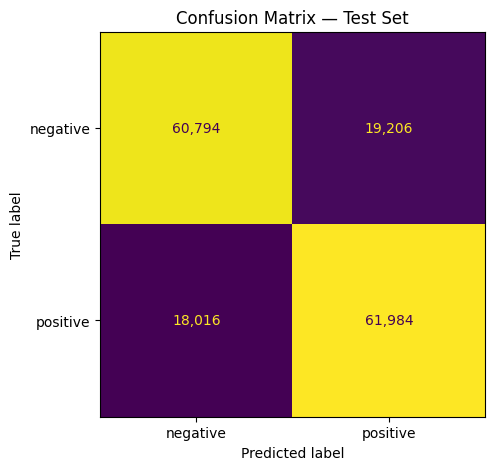

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the test set
test_preds = clf.predict(test_df["clean_text"])

# Ensure consistent label order
labels = list(clf.classes_)  # ["negative", "positive"]
cm = confusion_matrix(test_df["sentiment"], test_preds, labels=labels)

fig, ax = plt.subplots(figsize=(5.5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, values_format=",.0f", colorbar=False)
ax.set_title("Confusion Matrix — Test Set")
plt.show()


**Interpretation:**  
- High diagonal values indicate strong performance (correct classifications).  
- Off-diagonal values are the mistakes. A roughly symmetric matrix suggests the model treats both classes similarly.


## 📈 ROC & Precision–Recall Curves (Test)

We evaluate threshold-free performance using:
- **ROC curve** and **AUC** (overall ranking quality),
- **Precision–Recall curve** (especially informative with class imbalance; still useful here with balanced data).


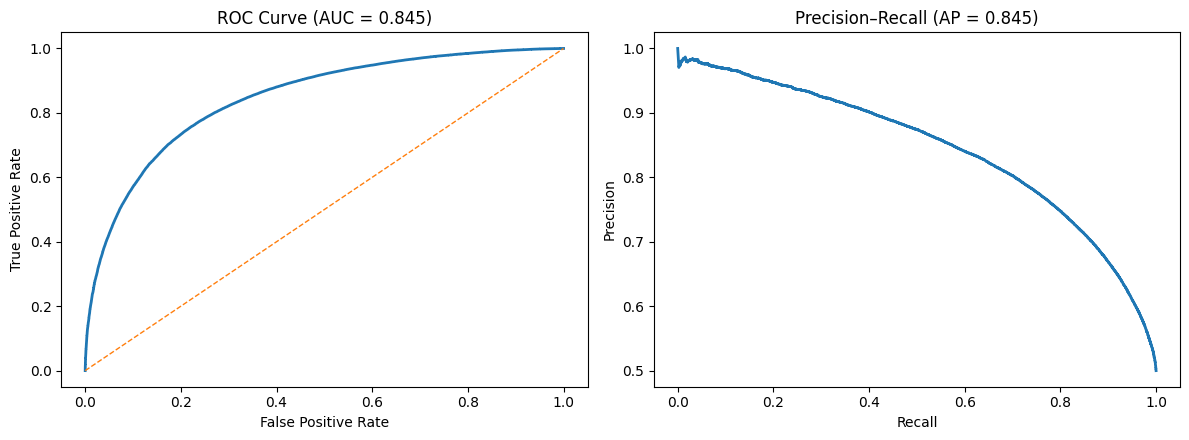

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Probabilities for the positive class
CLASSES = list(clf.classes_)
pos_idx = CLASSES.index("positive")
test_proba = clf.predict_proba(test_df["clean_text"])[:, pos_idx]

# Binarize ground truth: positive=1, negative=0
y_true = (test_df["sentiment"].values == "positive").astype(int)

# ROC
fpr, tpr, _ = roc_curve(y_true, test_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

# PR
prec, rec, _ = precision_recall_curve(y_true, test_proba, pos_label=1)
ap = average_precision_score(y_true, test_proba)

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

# ROC plot
ax[0].plot(fpr, tpr, lw=2)
ax[0].plot([0,1],[0,1], ls="--", lw=1)
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title(f"ROC Curve (AUC = {roc_auc:.3f})")

# PR plot
ax[1].plot(rec, prec, lw=2)
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title(f"Precision–Recall (AP = {ap:.3f})")

plt.tight_layout()
plt.show()


**Interpretation:**  
- **AUC** closer to 1.0 indicates strong separability between classes.  
- **Average Precision (AP)** summarizes the precision–recall trade-off; higher is better.


## 📦 Confidence Distribution by Class

We visualize the model’s predicted probability for the **positive** class, split by true label.  
This helps assess whether the model assigns **higher confidence** to positive examples and **lower confidence** to negative examples.


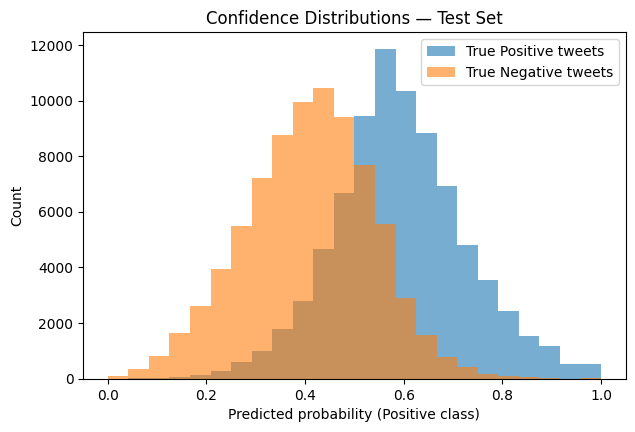

In [23]:
import numpy as np
import matplotlib.pyplot as plt

pos_scores_pos = test_proba[y_true == 1]
pos_scores_neg = test_proba[y_true == 0]

bins = np.linspace(0, 1, 25)

plt.figure(figsize=(7,4.5))
plt.hist(pos_scores_pos, bins=bins, alpha=0.6, label="True Positive tweets")
plt.hist(pos_scores_neg, bins=bins, alpha=0.6, label="True Negative tweets")
plt.xlabel("Predicted probability (Positive class)")
plt.ylabel("Count")
plt.title("Confidence Distributions — Test Set")
plt.legend()
plt.show()


**Interpretation:**  
- Ideally, **true positives** cluster near 1.0 and **true negatives** near 0.0.  
- Significant overlap suggests ambiguous or noisy examples (common in tweets).


## 🔍 Qualitative Review: Correct & Incorrect Predictions

Quantitative metrics are great; qualitative review helps explain behavior.  
Below we show the **most confident correct** predictions and the **most confident mistakes** from the Test set.


In [24]:
import pandas as pd
import numpy as np

# Get predictions + probs on test
preds = clf.predict(test_df["clean_text"])
proba = clf.predict_proba(test_df["clean_text"])[:, pos_idx]

review_df = pd.DataFrame({
    "text": test_df["text"].values,
    "true": test_df["sentiment"].values,
    "pred": preds,
    "p_positive": proba
})

# Mark correctness
review_df["correct"] = (review_df["true"] == review_df["pred"])

# Most confident correct positives / negatives
top_correct_pos = review_df[(review_df["correct"]) & (review_df["pred"]=="positive")]\
                  .sort_values("p_positive", ascending=False).head(10)

top_correct_neg = review_df[(review_df["correct"]) & (review_df["pred"]=="negative")]\
                  .sort_values("p_positive", ascending=True).head(10)

# Most confident mistakes (where model was very sure but wrong)
wrong_pos = review_df[(~review_df["correct"]) & (review_df["pred"]=="positive")]\
            .sort_values("p_positive", ascending=False).head(10)
wrong_neg = review_df[(~review_df["correct"]) & (review_df["pred"]=="negative")]\
            .sort_values("p_positive", ascending=True).head(10)

def shorten(s, n=160):
    s = str(s)
    return s if len(s) <= n else s[:n] + "…"

def preview_table(df):
    view = df.copy()
    view["text"] = view["text"].apply(lambda s: shorten(s, 140))
    return view[["text","true","pred","p_positive"]]

print("Top correct — Positive:")
display(preview_table(top_correct_pos))

print("Top correct — Negative:")
display(preview_table(top_correct_neg))

print("Confident mistakes — Predicted Positive but actually Negative:")
display(preview_table(wrong_pos))

print("Confident mistakes — Predicted Negative but actually Positive:")
display(preview_table(wrong_neg))


Top correct — Positive:


,text,true,pred,p_positive
94696,@showmesecrets thanks,positive,positive,0.985571
159996,@blu3id Thanks,positive,positive,0.985571
1860,@Vader101 Thanks!,positive,positive,0.985571
152709,@LiPeony thanks,positive,positive,0.985571
38333,@herangelwings Thanks!,positive,positive,0.985571
153658,@NancyEllyn thanks,positive,positive,0.985571
30387,@postalguarelas Thanks!!,positive,positive,0.985571
94759,@work4twilight Thanks,positive,positive,0.985571
57498,@TxCriMjr Thanks,positive,positive,0.985571
133424,@PawsitivelyPics thanks,positive,positive,0.985571


Top correct — Negative:


,text,true,pred,p_positive
26176,@chelseacriner http://twitpic.com/7hg32 - SAD,negative,negative,0.006660
29258,@conii_star i miss u!!,negative,negative,0.008348
89949,i miss @caauution,negative,negative,0.008348
70718,@imnatearchibald i miss u,negative,negative,0.008348
151239,I miss my @sebby_peek,negative,negative,0.012678
48401,@Lioness812 not u,negative,negative,0.013768
78270,@WeAreBrave not,negative,negative,0.013768
63065,@WOAHAmber I'm not,negative,negative,0.013768
52508,@MissBecky88 I'm not,negative,negative,0.013768
143708,@phil_hellmuth So sad,negative,negative,0.016269


Confident mistakes — Predicted Positive but actually Negative:


,text,true,pred,p_positive
32479,@IamSamL thanks,negative,positive,0.985571
86255,@Denise183rd thanks,negative,positive,0.985571
11467,@DuckDrake Thanks.,negative,positive,0.985571
30893,@agustinaimi thanks,negative,positive,0.985571
137500,@celestecupcake thanks,negative,positive,0.985571
71388,@Owl311 thanks,negative,positive,0.985571
120132,@shottayute. thank you,negative,positive,0.980574
6063,@KatMcGraw thank you!!,negative,positive,0.980574
52965,@ShylaRenee I love you.,negative,positive,0.964746
4172,@sonyasunshine i love you!,negative,positive,0.964746


Confident mistakes — Predicted Negative but actually Positive:


,text,true,pred,p_positive
121145,@saraliechty i'm not!,positive,negative,0.013768
58881,@rickmav y not?,positive,negative,0.013768
113832,@RealDeal32 NO!,positive,negative,0.026579
701,i miss my friends,positive,negative,0.055328
25406,Not too bad,positive,negative,0.056495
138253,@sweettart321 Wish I could!,positive,negative,0.059922
133520,tired. but now i have to go work,positive,negative,0.066796
16517,Too bad I'm not,positive,negative,0.067591
2750,Back to work,positive,negative,0.071169
211,@contentwhore not bad,positive,negative,0.078534


**Interpretation:**  
- **Top correct** rows illustrate the language patterns the model handles well.  
- **Confident mistakes** surface edge cases (sarcasm, slang, ambiguous context), which are common sources of error in social text.


## 📋 Per-Class Metrics Table (Test)

A compact table of **precision, recall, and F1** for each class on the Test set.


In [25]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, sup = precision_recall_fscore_support(
    test_df["sentiment"], preds, labels=CLASSES, zero_division=0
)

metrics_df = pd.DataFrame({
    "class": CLASSES,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": sup
})
display(metrics_df)


,class,precision,recall,f1,support
0,negative,0.771400,0.759925,0.765619,80000
1,positive,0.763444,0.774800,0.769080,80000


**Interpretation:**  
- Similar **precision/recall/F1** across both classes indicates the model performs **evenly** and is not biased toward one label.


# 🏁 Final Project Summary

In this project, we built an **end-to-end Sentiment Analysis pipeline** using the **Sentiment140 dataset** (1.6M tweets).  

### 🔑 Key Steps
- **Data Preparation:** Loaded and cleaned 1.6M raw tweets, keeping **Positive** and **Negative** sentiment classes.  
- **Splitting:** Created **80/10/10 stratified Train/Validation/Test splits** to ensure balanced evaluation.  
- **Modeling:** Trained a **scalable linear classifier** (`HashingVectorizer + TF-IDF + SGDClassifier`) for efficient learning on large-scale text data.  
- **Evaluation:** Achieved a **Macro-F1 ≈ 0.77** on both validation and test sets, confirming stable generalization.  
- **Visualization:** Added diagnostic plots (confusion matrix, ROC/PR curves, confidence histograms, qualitative error review) to better understand model performance.  
- **Deployment:** Exported the trained pipeline with `joblib` and deployed it via a **Streamlit app**, accessible both in Colab (using ngrok) and ready for GitHub/Streamlit Cloud hosting.

### 📊 What We Learned
- Linear models with TF-IDF remain **competitive baselines** for large-scale sentiment analysis, even compared to heavier deep learning models.  
- Proper **data cleaning** (URLs, mentions, hashtags) is critical in noisy social media text.  
- Evaluation beyond accuracy (F1, ROC, PR, error analysis) gives a **fuller picture** of strengths and weaknesses.  
- Deploying models via Streamlit provides an **engaging way to demonstrate skills** to recruiters or stakeholders.
  

---

✅ This notebook demonstrates the **full ML lifecycle**: from raw data → training → evaluation → deployment.  

